<div class = "alert alert-info>
              <h2>Imports</h2>
              </div>

<div class = "alert alert-info">
      <h2>Imports</h2>
                  </div>

In [1]:
import os
import re
import numpy as np
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import nltk
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from  keras.layers  import Embedding
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras import layers
from keras import preprocessing

Using TensorFlow backend.


<div class = "alert alert-info">
    <h2>Prétraitement</h2>
    <h3>Extraction du genre, division des oeuvres par actes, nettoyage des balises et suppression des mots vides</h3>
                  </div>

In [46]:
path = "corpus/theatreClassique/XML/"
liste = os.listdir(path)
stop_words = nltk.corpus.stopwords.words("french")
y = []
X = []

for texte in liste:
    
    try:

        f = open(path+texte,'r',encoding="utf-8")
        contenu = f.read()
        
    except UnicodeDecodeError:
        
        f = open(path+texte,'r',encoding="latin-1")
        contenu = f.read()
    
    contenu = re.sub("(\n\t*\s*)", "\n ", contenu)
    
    contenu = re.sub(r'\b(' + r'|'.join(stop_words) + r')\b\s*','', contenu)

    acts = re.findall('<div1 .*?>(.*?)</div1>',contenu,flags=re.DOTALL)

    y += re.findall('<genre>(.*?)</genre>',contenu)*len(acts)

    for i in range(len(acts)):

        X.append(re.sub('<.*?>', ' ', acts[i]))
        
    f.close()

len(X),len(y)

(3156, 3156)

<div class = "alert alert-info">
      <h2>Choix des données relevantes et suppression des duplications</h2>
                  </div>

In [47]:
classes = [x[0] for x in Counter(y).most_common() if x[1] >= 10]
print("we have {} classes that exist at least 10 times, these classes are:".format(len(classes)))
classes

we have 20 classes that exist at least 10 times, these classes are:


['Tragédie',
 'Comédie',
 'Tragi-comédie',
 'Opéra',
 'Drame',
 'Proverbe',
 'Pastorale',
 'Comédie héroïque',
 'Monologue',
 'Tragédie musique',
 'Farce',
 'opuscule dramatique',
 'Comédie-ballet',
 'Opéra comique',
 'Parodie',
 'Pastorale héroïque',
 'Tragédie lyrique',
 'Comédie galante',
 'Ballet',
 'Divertissement']

In [48]:
most_common = Counter(y).most_common(len(classes))
most_common

[('Tragédie', 1190),
 ('Comédie', 1096),
 ('Tragi-comédie', 348),
 ('Opéra', 70),
 ('Drame', 65),
 ('Proverbe', 43),
 ('Pastorale', 28),
 ('Comédie héroïque', 27),
 ('Monologue', 24),
 ('Tragédie musique', 23),
 ('Farce', 19),
 ('opuscule dramatique', 19),
 ('Comédie-ballet', 19),
 ('Opéra comique', 17),
 ('Parodie', 17),
 ('Pastorale héroïque', 15),
 ('Tragédie lyrique', 14),
 ('Comédie galante', 11),
 ('Ballet', 11),
 ('Divertissement', 10)]

In [58]:
nbre_acts = np.sum([x[1] for x in most_common])

maxlen = np.max([len(x.split(" ")) - np.sum(np.array(x.split(" ")) == "") for x in X])
minlen = np.min([len(x.split(" ")) - np.sum(np.array(x.split(" ")) == "") for x in X])
meanlen = np.mean([len(x.split(" ")) - np.sum(np.array(x.split(" ")) == "") for x in X])

print("The overall dataset now is about {} acts".format(nbre_acts))
print("the mean number of words (including punctuations) in an act is {}".format(meanlen))
print("the max number of words (including punctuations) in an act is {}".format(maxlen))
print("the min number of words (including punctuations) in an act is {}".format(minlen))

The overall dataset now is about 3066 acts
the mean number of words (including punctuations) in an act is 2895.78010139417
the max number of words (including punctuations) in an act is 20030
the min number of words (including punctuations) in an act is 75


In [50]:
df = pd.DataFrame({"Acts":np.array(X),"Labels":np.array(y)})

data = df[df["Labels"].apply(lambda x: x in classes)]

In [51]:
data.describe()

,Acts,Labels
count,3066,3066
unique,3060,20
top,ANNEXES \t\n Liste oeuvres théâtrales Jean ...,Tragédie
freq,4,1190


In [52]:
data = data.drop_duplicates()

In [53]:
data.describe()

,Acts,Labels
count,3060,3060
unique,3060,20
top,"\n SCÈNE I. \n MERLIN, seul. \n Charonn...",Tragédie
freq,1,1184


In [54]:
data["Labels"] = pd.Categorical(data["Labels"])

data["LabelsNum"] = data["Labels"].cat.codes

<div class = "alert alert-info">
      <h2>Préparation à l'entrainement - distribution identique par classe </h2>
                  </div>

In [55]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(test_size = 0.25)

acts = data["Acts"].values
labels = data["LabelsNum"].values

for train_index, test_index in sss.split(acts,labels):
    
    X_train, X_test = acts[train_index], acts[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

In [56]:
X_train.shape,X_test.shape

((2295,), (765,))

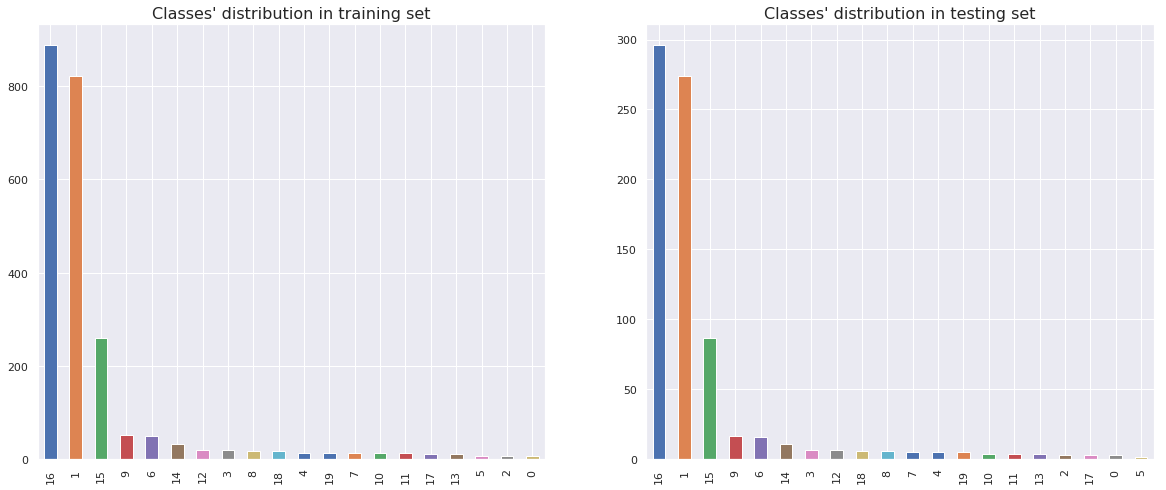

In [57]:
sns.set()
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.title("Classes' distribution in training set",fontsize = 16)
pd.Series(y_train).value_counts().plot(kind='bar')

plt.subplot(122)
plt.title("Classes' distribution in testing set",fontsize = 16)
pd.Series(y_test).value_counts().plot(kind='bar')

plt.show()

<div class="alert alert-info">
    <h2>Word Embedding</h2>
    </div>

In [ ]:
maxlen = 99654  # We will cut reviews after 100 words
training_samples = len(y_train)  # We will be training on 200 samples
validation_samples = len(y_test)  # We will be validating on 10000 samples
#max_words = 10000  # We will only consider the top 10,000 words in the dataset
texts=X_train
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [ ]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

x_train = data[: training_samples]

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
#x_test = data[training_samples: training_samples + validation_samples]
#y_test = labels[training_samples: training_samples + validation_samples]

In [ ]:
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)


In [ ]:
y_train=pd.get_dummies(y_train)

In [ ]:
model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
model.add(Embedding(94517, 64, input_length=maxlen))
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 8)`.

# We flatten the 3D tensor of embeddings 
# into a 2D tensor of shape `(samples, maxlen * 8)`
model.add(Flatten())
#model.add(layers.Dense(100,activation='relu'))

# We add the classifier on top
model.add(Dense(20, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=5,
                    batch_size=32,
                    validation_split=0.2)